# B/C vs q Classifier

This notebook trains a GNN for binary classifictaion of b-jets and c-jets vs light-jets. Requires Python 3.9 and  "gnn_env" conda environment on sneezy. Skip to training performance to load training plots. If training is redone, manually update names for outputs (e.g. change outputs like full_bcq_model1.pth to full_bcq_model2.pth to prevent overwriting previous training).

* This notebook does not include pT > 50 GeV
* Data is processed in this notebook instead of "process_data.ipynb"

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import random
import uproot

In [ ]:
# Check if GPU is available
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [4]:
# Read b dijet ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=5000) #select how many events to load or remove entry_start/stop to load all events

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

# Read c dijet ROOT file
tree = uproot.open("Dijet_cc_pt20_50_dw.root" + ":" + path_to_tree)
cc_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=5000)

# Clean column names and remove unwanted columns
cc_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc_df.columns]
rename_columns(cc_df)
columns_to_remove = [col for col in cc_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc_df.drop(columns=columns_to_remove, inplace=True)
for col in cc_df.columns:
    if "SVtag" in col:
        cc_df[col] = cc_df[col].apply(extract_float)
tree.close()

# Read light dijet ROOT file
tree = uproot.open("Dijet_qq_pt20_50_dw.root" + ":" + path_to_tree)
qq_df = tree.arrays(tree.keys(), library="pd", entry_start=0, entry_stop=5000) 

# Clean column names and remove unwanted columns
qq_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in qq_df.columns]
rename_columns(qq_df)
columns_to_remove = [col for col in qq_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
qq_df.drop(columns=columns_to_remove, inplace=True)
for col in qq_df.columns:
    if "SVtag" in col:
        qq_df[col] = qq_df[col].apply(extract_float)
tree.close()

# (ignore warnings - only happens when using GPU)

/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [5]:
# Check how many events loaded for each
print(f'There are {len(bb_df)} b-jet events (signal)')
print(f'There are {len(cc_df)} c-jet events (signal)')
print(f'There are {len(qq_df)} q-jet events (background)')

There are 5000 b-jet events (signal)
There are 5000 c-jet events (signal)
There are 5000 q-jet events (background)


In [6]:
# Apply cuts and truth matching
bb_df = bb_df[(bb_df['Jet0_MC_Match'] == 1) &
                (bb_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (bb_df['Jet0_PT'] > 20000) &
                (bb_df['Jet0_Eta'].between(2.2, 4.4))]
cc_df = cc_df[(cc_df['Jet0_MC_Match'] == 1) &
                (cc_df['Jet0_MC_Jet_EfD'] > 0.6) &
                (cc_df['Jet0_PT'] > 20000) &
                (cc_df['Jet0_Eta'].between(2.2, 4.4))]
qq_df = qq_df[(qq_df['Jet0_MC_Match'] == 1) &
                (qq_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (qq_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (qq_df['Jet0_PT'] > 20000) &
                (qq_df['Jet0_Eta'].between(2.2, 4.4))]

# Write selected events into signal and background dfs
sig_df = pd.concat([bb_df, cc_df]).reset_index(drop=True)
bkg_df = qq_df

# Assign truth labels as new column
sig_df['IsBC'] = 1
bkg_df['IsBC'] = 0

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsBC")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsBC")]]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

/tmp/ipykernel_4982/3204801559.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bkg_df['IsBC'] = 0


In [7]:
print(f"Efficiency of signal truth matching is: {len(sig_df)/(sum([len(bb_df), len(cc_df)])):.4f}")
print(f"Efficiency of background truth matching is: {len(bkg_df)/len(qq_df):.4f}")
print('')
print(f"Total events after truth matching: {len(combined_df)}")
print(f"Number of b/c-jets after truth matching: {len(sig_df)}")

Efficiency of signal truth matching is: 1.0000
Efficiency of background truth matching is: 1.0000

Total events after truth matching: 4545
Number of b/c-jets after truth matching: 2841


In [ ]:
# Define feature columns including jet-level and daughter-level features

# Select any columns including daughters info
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]

# Select certain SV tagging variables for feautre input
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']

# Use eta, pT and SV tagging variables for jet-level features
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
# Use daughters vairables and jet variables for features input
feature_cols = daughter_cols + jet_cols

# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

# Remove lists and duplicate jet-level features for combined df
df = prepare_features(combined_df, jet_cols, daughter_cols)

Separate training and testing data

In [9]:
# Separate signal and background data again using truth labels and shuffle
sig_df = df[df['IsBC'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = df[df['IsBC'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

# Split 80% for training data and 20% for testing data
half_train_size = int((sum(combined_df.IsBC)*0.8)/2)
half_test_size = int((sum(combined_df.IsBC)*0.2)/2)

train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of training data is: {len(train_df)}')

test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of testing data is: {len(test_df)}')

# Select remaining events for "validation data"
validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of validation data is: {len(validation_df)}')

Length of training data is: 2272
Length of testing data is: 568
Length of validation data is: 1705


In [10]:
# Verify that there are equal amounts of sig/ bkg selected for training and testing data

print('Ratio of bc to q in datasets:')
print(f'    Training data: {sum(train_df.IsBC)/len(train_df)}')
print(f'    Testing data: {sum(test_df.IsBC)/len(test_df)}')
print(f'    Validation data: {sum(validation_df.IsBC)/len(validation_df)}')

Ratio of bc to q in datasets:
    Training data: 0.5
    Testing data: 0.5
    Validation data: 0.8334310850439882


# Create Graphs
Jet-level features are duplicated to match number of daughters per event (since daughter features are stores as lists for each daughter). Graphs are constructed with one graph for each leading jet event. Each node within the graph corresponds to a daughter particle within that jet (different numebr of nodes per each graph). Each node has (already duplicated) jet-level features and daughter-level features. All nodes are connected to each other through edges wihtin the graphs.

In [11]:
# Create graphs for training and testing data
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsBC'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Classifier

Run this cell to use classifer to plot training performance:

In [ ]:
# Define GNN architecture

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels) #input layer must match number of features columns
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1) # single output
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch):        
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1) # returns single output
    
model = GNN()
model = model.to(device)

# Change model/ training names to prevent overwriting. Skip this cell to see output of previous training.

In [ ]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss() # loss function for binary classification
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device) 
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float() # convert logits to predictions: positive output --> 1 class (sig), negative output --> 0 class (bkg)
            correct = (pred.squeeze() == data.y.float()).sum().item() # compare predictions to truth labels (data.y)
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 200

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    # Print outputs for each epoch
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Update csv outputs here! (model, training data)
    # full_bcq_model1.pth, full_bcq_training1.csv --> full 2m event training

    # Save the model and results every 50 epochs
    if (epoch + 1) % 50 == 0:
        # Overwrite the existing model file
        torch.save(model.state_dict(), 'full_bcq_model1.pth')
        print('Model saved as full_bcq_model1.pth.')

        # Save the loss and accuracy values to a CSV file, overwriting the existing file
        results_df = pd.DataFrame({
            'Epoch': list(range(1, epoch + 2)),
            'Train Loss': train_loss_values,
            'Test Loss': test_loss_values,
            'Train Accuracy': train_acc_values,
            'Test Accuracy': test_acc_values
        })
        results_df.to_csv('full_bcq_training1.csv', index=False)
        print('Training results saved as full_bcq_training1.csv.')

torch.save(model.state_dict(), 'full_bcq_model1.pth')
print('Model saved as full_bcq_model1.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

# Save the loss and accuracy values to a CSV file
results_df.to_csv('full_bcq_training1.csv', index=False)
print('Training results saved as full_bcq_training1.csv. Training complete.')

Epoch: 001, Train Loss: 0.5643, Test Loss: 0.5136, Train Acc: 0.7276, Test Acc: 0.7232
Epoch: 002, Train Loss: 0.5153, Test Loss: 0.5086, Train Acc: 0.7272, Test Acc: 0.7234
Epoch: 003, Train Loss: 0.5077, Test Loss: 0.5050, Train Acc: 0.7289, Test Acc: 0.7253
Epoch: 004, Train Loss: 0.5035, Test Loss: 0.5002, Train Acc: 0.7319, Test Acc: 0.7283
Epoch: 005, Train Loss: 0.5011, Test Loss: 0.4999, Train Acc: 0.7324, Test Acc: 0.7278
Epoch: 006, Train Loss: 0.4996, Test Loss: 0.5006, Train Acc: 0.7313, Test Acc: 0.7278
Epoch: 007, Train Loss: 0.4978, Test Loss: 0.4978, Train Acc: 0.7321, Test Acc: 0.7291
Epoch: 008, Train Loss: 0.4968, Test Loss: 0.4984, Train Acc: 0.7308, Test Acc: 0.7277
Epoch: 009, Train Loss: 0.4959, Test Loss: 0.4943, Train Acc: 0.7332, Test Acc: 0.7293
Epoch: 010, Train Loss: 0.4947, Test Loss: 0.4943, Train Acc: 0.7335, Test Acc: 0.7301
Epoch: 011, Train Loss: 0.4945, Test Loss: 0.4947, Train Acc: 0.7331, Test Acc: 0.7308
Epoch: 012, Train Loss: 0.4942, Test Loss: 

# Visualize training performance

In [13]:
# Reload training data to produce plots - can skip to here if training completed
training = pd.read_csv('full_bcq_training1.csv')
train_loss_values = training['Train Loss'].to_list()
test_loss_values = training['Test Loss'].to_list()
train_acc_values = training['Train Accuracy'].to_list()
test_acc_values = training['Test Accuracy'].to_list()

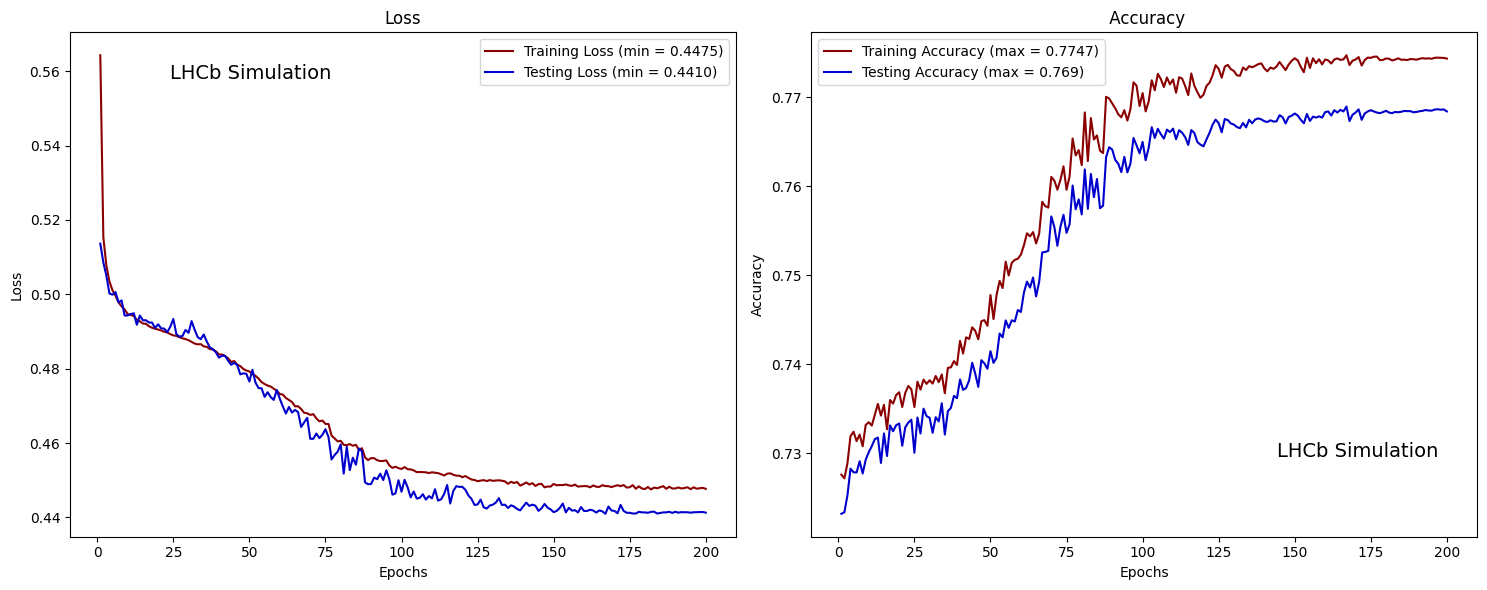

In [ ]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    # min/ max/ mean values for adding to legend
    mean_train_loss = np.mean(train_loss_values)
    mean_test_loss = np.mean(test_loss_values)
    mean_train_acc = np.mean(train_acc_values)
    mean_test_acc = np.mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    #fig.suptitle('Training Results', fontsize=16) # optional title

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))

    ax1.text(0.15, 0.90, "LHCb Simulation", transform=ax1.transAxes, fontsize=14, verticalalignment='bottom')

    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4})"))

    ax2.text(0.7, 0.15, "LHCb Simulation", transform=ax2.transAxes, fontsize=14, verticalalignment='bottom')

    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
plot_training_results()

Make predictions using trained GNN - calculate tpr, fpr, thresholds (cutoffs for certain probabiltities), and auc. Requires data loaded into graphs.

In [ ]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.load_state_dict(torch.load('full_bcq_model1.pth')) # must run the cell containing model arhictecture to now load previous weights
model = model.to('cpu')
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Save each array separately - update names to prevent overwriting
np.save('full_bcq_fpr.npy', fpr)
np.save('full_bcq_tpr.npy', tpr)
np.save('full_bcq_thresholds.npy', thresholds)
np.save('full_bcq_auc.npy', auc)

In [ ]:
# Get FPRs for TPRs
desired_tpr = [0.85, 0.80, 0.75, 0.70, 0.65, 0.60]

print("Efficiency | FPR ")
for val in desired_tpr:
    # Find the index of the closest TPR to the desired TPR value
    closest_index = np.argmin(np.abs(tpr - val))

    # Get the chosen threshold and corresponding FPR, where the threshold is the probability cutoff
    chosen_threshold = thresholds[closest_index]
    given_fpr = fpr[closest_index]
    print(f"{val}: {given_fpr:.4f}")

Efficiency | FPR 
0.85: 0.3380
0.8: 0.2746
0.75: 0.2148
0.7: 0.1796
0.65: 0.1479
0.6: 0.1268


In [17]:
# Choose a tpr, find closest threshold and given probability
chosen_tpr = 0.75
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pbc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.75: Pbc 0.4618: FPR 0.2148


Generate confusion matrix to compare TPR, FPR

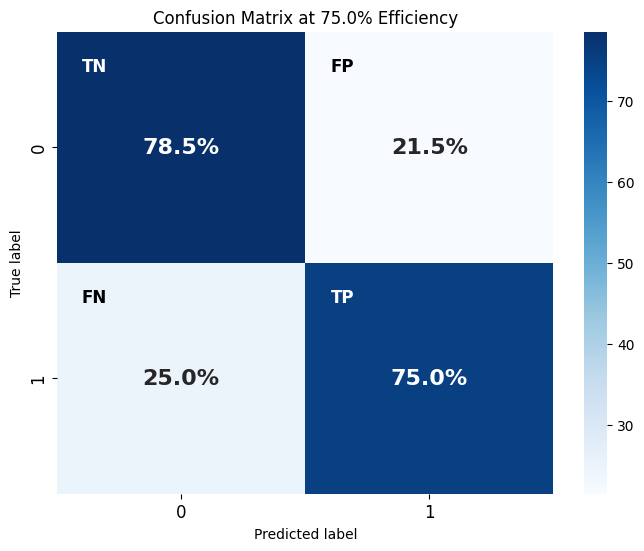

In [34]:
# Choose efficency: chosen_threshold is given p cutoff 
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

# Uses percent tpr/ fpr for labels
annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

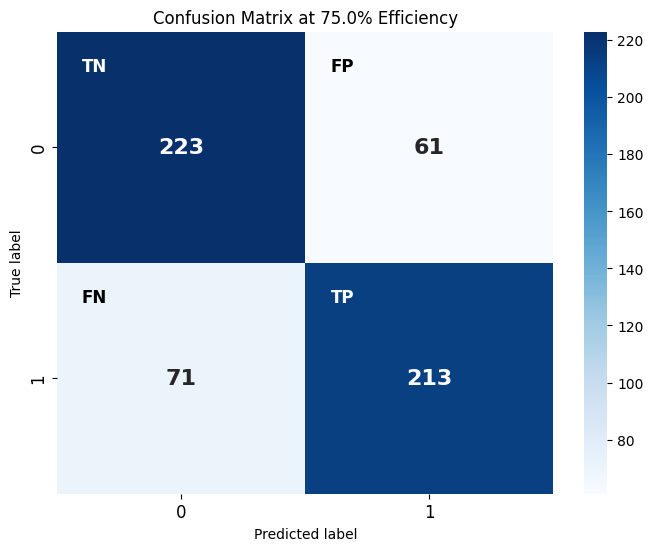

In [ ]:
# Choose efficency: chosen_threshold is given p cutoff 
y_pred_binary = (y_scores >= chosen_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Uses number of events with tp/ fp, etc
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f"Confusion Matrix at {chosen_tpr*100}% Efficiency")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

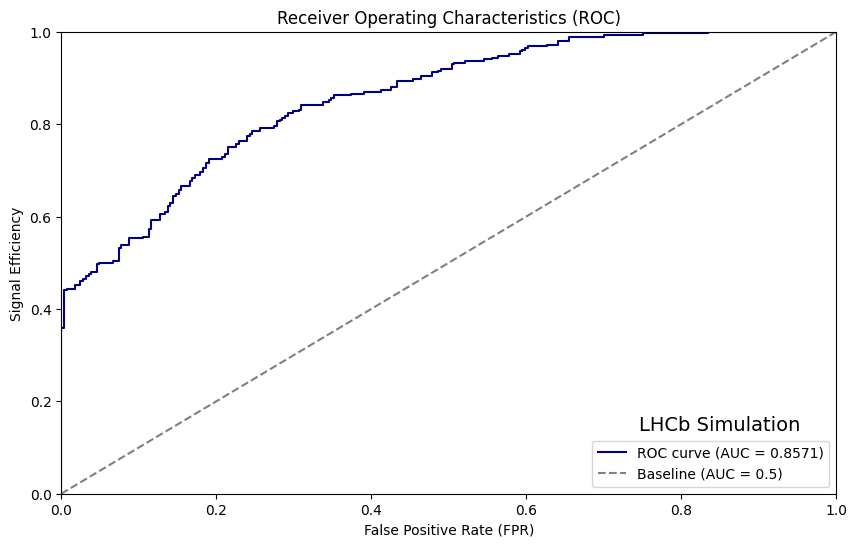

In [20]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.text(0.85, 0.15, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.legend(loc='lower right')
plt.show()

# Plot feature importance

Feature ablation: perturb one feature at a time and compare performance

                                Feature  Importance
0                      Jet0_Daughters_E    0.653061
1                     Jet0_Daughters_pT    0.889286
2                     Jet0_Daughters_ID    0.049326
3                     Jet0_Daughters_pX    0.658604
4                     Jet0_Daughters_pY    0.413537
5                     Jet0_Daughters_pZ    1.060663
6                    Jet0_Daughters_Eta    0.004495
7                    Jet0_Daughters_Phi    0.001417
8                      Jet0_Daughters_Q    0.000222
9                     Jet0_Daughters_IP    0.036437
10                Jet0_Daughters_IPCHI2    0.890880
11                 Jet0_Daughters_IPraw    0.020722
12                   Jet0_Daughters_NNe    0.418409
13                   Jet0_Daughters_NNk    0.104455
14                   Jet0_Daughters_NNp    0.461007
15                  Jet0_Daughters_NNpi    0.206619
16                  Jet0_Daughters_NNmu    1.049367
17                  Jet0_Daughters_Chi2    0.233396
18          

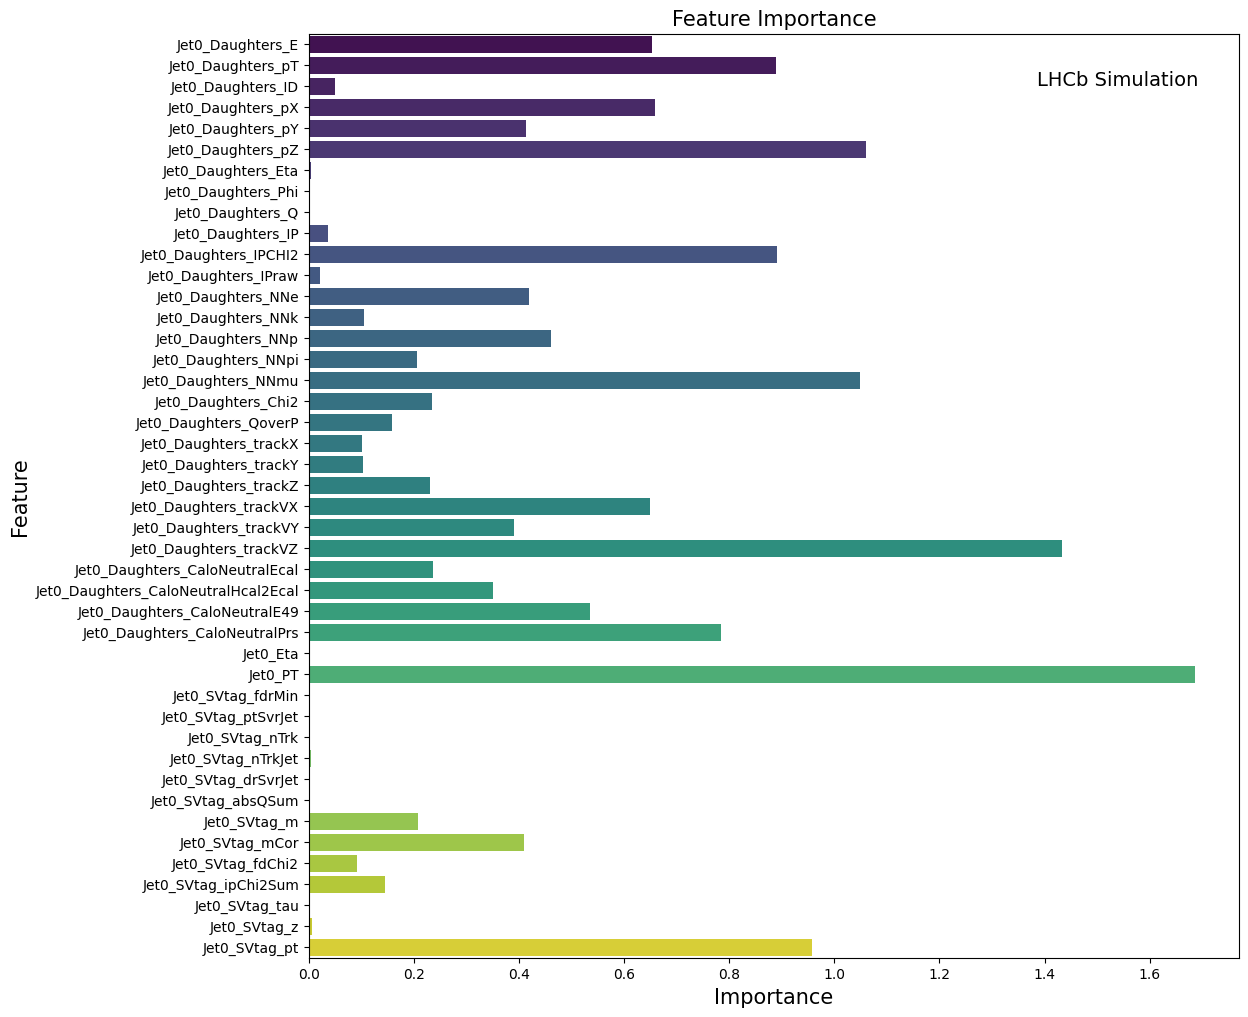

In [ ]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy())) # take edges from edge index and add to graph
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1)) # zero array with size of features

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone() # copy of x (node feature matrix)
    x_perturbed[:, feature_idx] = 0 # set feature to 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred)) # difference in predictions
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance', fontsize=15)
plt.text(0.87, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.show()

In [ ]:
# Print features and importance with values > 0.25 (& helpful for importing to latex)
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_Daughters_E & 0.653061
Jet0_Daughters_pT & 0.889286
Jet0_Daughters_pX & 0.658604
Jet0_Daughters_pY & 0.413537
Jet0_Daughters_pZ & 1.060663
Jet0_Daughters_IPCHI2 & 0.890880
Jet0_Daughters_NNe & 0.418409
Jet0_Daughters_NNp & 0.461007
Jet0_Daughters_NNmu & 1.049367
Jet0_Daughters_trackVX & 0.648603
Jet0_Daughters_trackVY & 0.390025
Jet0_Daughters_trackVZ & 1.432456
Jet0_Daughters_CaloNeutralHcal2Ecal & 0.350130
Jet0_Daughters_CaloNeutralE49 & 0.534998
Jet0_Daughters_CaloNeutralPrs & 0.784990
Jet0_PT & 1.685487
Jet0_SVtag_mCor & 0.409973
Jet0_SVtag_pt & 0.958248


# Model Probability Output
Choose a random event from validation df, process into graph, and use GNN to make prediction

In [37]:
df = validation_df

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Select columns containing Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns - must match features used for training
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    # Copy jet features to length of daughters and remove unwanted formating (lists)
    for col in jet_cols:
        sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    # Feed graph into classifier
    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int() # chosen threshold is defined up higher, can use 0.5 or change depending on desired WP, here WP = 0.75 (tpr)

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: b/c-jet')
    if prediction.item() == 0:  
        print(f'Prediction: q-jet')
    return probability.item()

i = 0

for i in range(100):
    make_predictions()

Probability: 0.9998869895935059
Prediction: b/c-jet
Probability: 0.502848207950592
Prediction: b/c-jet
Probability: 0.48541203141212463
Prediction: b/c-jet
Probability: 0.24531692266464233
Prediction: q-jet
Probability: 0.4319314956665039
Prediction: q-jet
Probability: 0.9961249232292175
Prediction: b/c-jet
Probability: 0.49444660544395447
Prediction: b/c-jet
Probability: 0.9960669875144958
Prediction: b/c-jet
Probability: 0.015662340447306633
Prediction: q-jet
Probability: 0.9981755018234253
Prediction: b/c-jet
Probability: 0.994530975818634
Prediction: b/c-jet
Probability: 0.5918504595756531
Prediction: b/c-jet
Probability: 0.07118716835975647
Prediction: q-jet
Probability: 0.4739464223384857
Prediction: b/c-jet
Probability: 0.9799491763114929
Prediction: b/c-jet
Probability: 0.552376389503479
Prediction: b/c-jet
Probability: 0.9971455931663513
Prediction: b/c-jet
Probability: 0.9984473586082458
Prediction: b/c-jet
Probability: 0.08729790896177292
Prediction: q-jet
Probability: 0.996

# Create Efficiency Plot

In [ ]:
model.load_state_dict(torch.load('full_bcq_model1.pth')) # load trained model
model = model.to('cpu')

This creates probability distribution by separating the sig/ bkg events and feeding them into the classifier.

In [ ]:
# Separate bc and q data from testing dataset
bc = test_df[test_df.IsBC == 1]
q = test_df[test_df.IsBC == 0]

bc_data = create_graphs(bc, feature_cols)
q_data = create_graphs(q, feature_cols)

bc_prob = []
q_prob = []

def get_probabilities(data_list):
    prob_list = []
    model.eval()
    with torch.no_grad():
        for data in data_list:
            out = model(data.x, data.edge_index, data.batch)
            prob = torch.sigmoid(out).numpy().flatten()
            prob_list.append(prob)
    return np.concatenate(prob_list)

# Compute probabilities for bc and q data
bc_prob = get_probabilities(bc_data)
q_prob = get_probabilities(q_data)

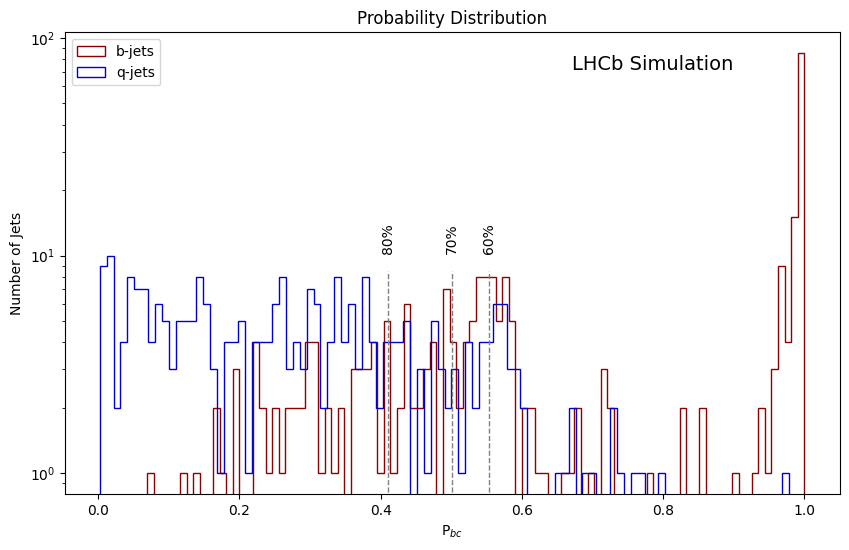

In [ ]:
def plot_probability_distribution(bc_prob, q_prob, target_efficiencies):

    # Sort b-jet probabilities in descending order for cutoff calculations
    sorted_b_prob = np.sort(bc_prob)[::-1]
    
    # Calculate cutoffs for each efficiency level
    cutoffs = {}
    for efficiency in target_efficiencies:
        cutoff_index = int(len(sorted_b_prob) * efficiency) # events sorted to keep highest (target efficiency)% probabilities
        cutoffs[efficiency] = sorted_b_prob[cutoff_index - 1] if cutoff_index > 0 else sorted_b_prob[0]
    
    # Plot histograms for b-jet and q-jet probabilities
    plt.figure(figsize=(10, 6))
    bc_values, bc_bins, _ = plt.hist(bc_prob, bins=100, label='b-jets', color='darkred', histtype='step')
    q_values, q_bins, _ = plt.hist(q_prob, bins=100, label='q-jets', color='mediumblue', histtype='step')

    max_y = max(max(bc_values), max(q_values))
    
    # Mark cutoffs for selected efficiencies
    for i, (efficiency, cutoff) in enumerate(cutoffs.items()):
        plt.vlines(x=cutoff, ymin=0, ymax=max_y * 0.1, color='grey', linestyle='--', linewidth=1)
        plt.text(cutoff, max_y*0.12, f'{int(efficiency * 100)}%', ha='center', va='bottom', rotation=90)

    plt.xlabel("P$_{bc}$")
    plt.ylabel("Number of Jets")
    plt.text(0.9, max_y * 0.8, "LHCb Simulation", fontsize=14, verticalalignment='bottom', horizontalalignment='right')
    plt.title("Probability Distribution")
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

target_efficiencies = [0.6, 0.7, 0.8] # which efficiencies to show on plot
plot_probability_distribution(bc_prob, q_prob, target_efficiencies)

In [ ]:
# Select WP and find corresponding prob cutoff
chosen_tpr = 0.75
closest_index = np.argmin(np.abs(tpr - chosen_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {chosen_tpr}: Pbc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.75: Pbc 0.4618: FPR 0.2148


# Plot Efficiencies vs pT

In [ ]:
# Select signal data from test_df
bc = test_df[test_df.IsBC == 1]
bc.loc[:, 'Jet0_PT'] = bc['Jet0_PT'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Create new dfs for different pT ranges
pt23_df = bc[(bc['Jet0_PT'].between(20000, 30000))].reset_index(drop=True)
pt34_df = bc[(bc['Jet0_PT'].between(30000, 40000))].reset_index(drop=True)
pt45_df = bc[(bc['Jet0_PT'].between(40000, 50000))].reset_index(drop=True)

In [ ]:
# Feed data into GNN and count number of correct predictions
def make_predictions(df):
    daughter_cols = [col for col in df.columns if "_Daughters" in col]
    svtag_cols = [
        'Jet0_SVtag_fdrMin',
        'Jet0_SVtag_ptSvrJet',
        'Jet0_SVtag_nTrk',
        'Jet0_SVtag_nTrkJet',
        'Jet0_SVtag_drSvrJet',
        'Jet0_SVtag_absQSum',
        'Jet0_SVtag_m',
        'Jet0_SVtag_mCor',
        'Jet0_SVtag_fdChi2',
        'Jet0_SVtag_ipChi2Sum',
        'Jet0_SVtag_tau',
        'Jet0_SVtag_z',
        'Jet0_SVtag_pt'
    ]
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Get features of each node within the graph
    features_list = []
    for _, row in df.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    num_bc = 0
    for data in data_objects:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > chosen_threshold).int()

            # Count how many times bc-jets are predicted from sample of only bc jets
            if prediction.item() == 1:  
                num_bc += 1

    return num_bc

In [ ]:
# Make predictions for each pT range
num_bc23 = make_predictions(pt23_df)
num_bc34 = make_predictions(pt34_df)
num_bc45 = make_predictions(pt45_df)

# Calculate efficiencies
efficiency23 = num_bc23 / len(pt23_df)
efficiency34 = num_bc34 / len(pt34_df)
efficiency45 = num_bc45 / len(pt45_df)

print(f'Efficiency for pT 20-30 GeV: {efficiency23:.4f}')
print(f'Efficiency for pT 30-40 GeV: {efficiency34:.4f}')
print(f'Efficiency for pT 40-50 GeV: {efficiency45:.4f}')

Efficiency for pT 20-30 GeV: 0.7457
Efficiency for pT 30-40 GeV: 0.6933
Efficiency for pT 40-50 GeV: 0.8929


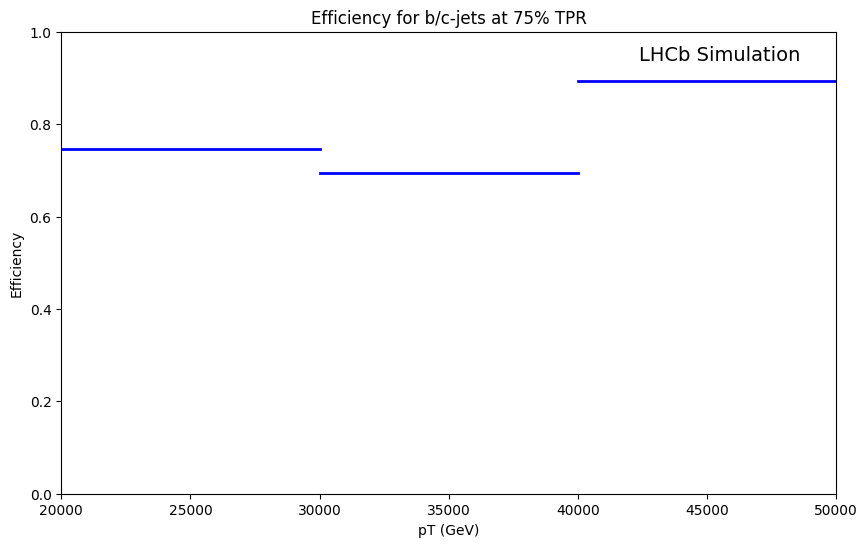

In [ ]:
# Plot efficiencies for each pT bin
def plot_efficiency_histogram(efficiencies, pt_bins):
    plt.figure(figsize=(10, 6))

    # Calculate bin centers and widths
    bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
    bar_width = np.diff(pt_bins)  # Width of the bins

    # Create the histogram by plotting only the tops of the bins
    for i in range(len(efficiencies)):
        plt.plot([pt_bins[i], pt_bins[i+1]], [efficiencies[i], efficiencies[i]], color='blue', linewidth=2)
    plt.xticks(np.arange(20000, 51000, 5000))
    plt.xlabel('pT (GeV)')
    plt.ylabel('Efficiency')
    plt.text(0.85, 0.95, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
    plt.title('Efficiency for b/c-jets at 75% TPR')
    plt.ylim(0, 1)
    plt.xlim(20000,50000)
    plt.show()

# Define bin ranges
pt_bins = np.array([20000, 30000, 40000, 50000])
efficiencies = [efficiency23, efficiency34, efficiency45]

plot_efficiency_histogram(efficiencies, pt_bins)

Plot ROC curves together (after all classifiers are trained)

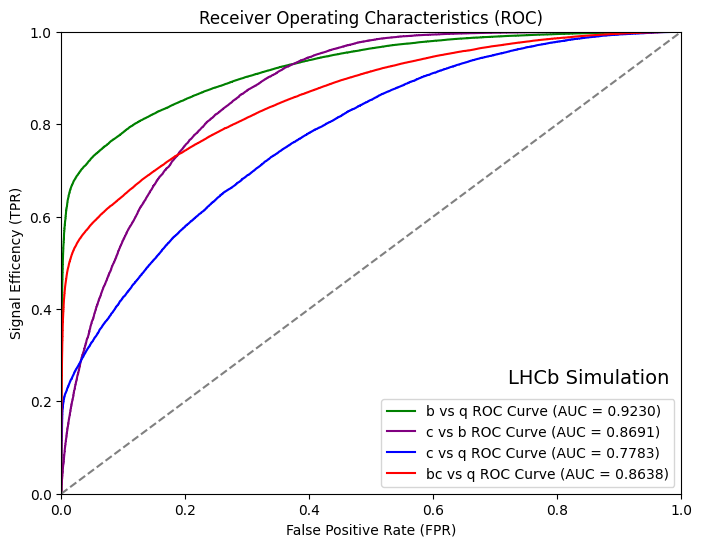

In [ ]:
# Load ROC data
fpr1, tpr1, thresholds1, auc1 = np.load('full_bq_roc_data2.npy', allow_pickle=True)
fpr2, tpr2, thresholds2, auc2 = np.load('full_cb_roc_data1.npy', allow_pickle=True)
fpr3, tpr3, thresholds3, auc3 = np.load('full_cq_roc_data1.npy', allow_pickle=True)
fpr4, tpr4, thresholds4, auc4 = np.load('full_bcq_roc_data1.npy', allow_pickle=True)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'b vs q ROC Curve (AUC = {auc1:.4f})', color='green')
plt.plot(fpr2, tpr2, label=f'c vs b ROC Curve (AUC = {auc2:.4f})', color='purple')
plt.plot(fpr3, tpr3, label=f'c vs q ROC Curve (AUC = {auc3:.4f})', color='blue')
plt.plot(fpr4, tpr4, label=f'bc vs q ROC Curve (AUC = {auc4:.4f})', color='red')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Labels and legend
plt.text(0.85, 0.25, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('Signal Efficency (TPR)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.show()